In [1]:
import json
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GROUP_MAP = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP = {k.replace(':', '_'): v for k, v in GROUP_MAP.items()}

GROUP_MAP_CEQ = {
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP_CEQ = {k.replace(':', '_'): v for k, v in GROUP_MAP_CEQ.items()}

GROUP_MAP_CW = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
}
GROUP_MAP_CW = {k.replace(':', '_'): v for k, v in GROUP_MAP_CW.items()}

model_order = ["qwen", "qwen2", "desta2_5", "blsp-emo"]


# closed_ended_questions

In [3]:
df_audio_task_ceq = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_ceq[audio_task] = pd.read_excel(f"./analysis/summary_ceq.xlsx", sheet_name=f"{audio_task}_grouped")

In [4]:
MAP_AUDIO_TASK = {
    "ASR": "Automatic_speech_recognition",
    "SER": "Speech_emotion_recognition",
    "GR": "Gender_recognition",
    # "MMAU": "MMAU", # not implemented yet
}

MAP_MODEL_NAME = {
    "qwen": "Qwen-Audio",
    "qwen2": "Qwen2-Audio",
    "desta2_5": "DeSTA2.5-Audio",
    "blsp-emo": "BLSP-Emo",
}

## Plots

### IF-rate

In [5]:
from typing import Optional, Union


def plot_metric_by_shot_level(
    df_audio_task:dict[str, pd.DataFrame],
    audio_task: str,
    response_task: str,
    IF_task_groups: list[str],
    figsize:Optional[tuple[int, int]]=None,
    ylim:Optional[tuple[float, float]]=None,
    model_order:list[str]=model_order,
    metric_name:str='mean_performance',
) -> None:
    audio_task_formatted = MAP_AUDIO_TASK.get(audio_task, audio_task).replace('_', ' ').title()
    try:
        tmp = df_audio_task[f"{audio_task}_grouped"]
    except KeyError:
        tmp = df_audio_task[audio_task]
    for IF_task_group in IF_task_groups:
        if figsize is not None:
            plt.figure(figsize=figsize)
        else:
            plt.figure()
        for model in model_order:
            tmp_model = tmp[(tmp['IF_task_group'] == IF_task_group) & (tmp['model'] == model)]
            plt.plot(tmp_model['shot_level'], tmp_model[metric_name], marker='o', label=MAP_MODEL_NAME.get(model, model))
        IF_task_group_formatted = IF_task_group.replace('_', ' ').title()
        IF_task_group_formatted = "JSON Format" if IF_task_group_formatted == "Json Format" else IF_task_group_formatted
        if IF_task_group_formatted == "Startend":
            IF_task_group_formatted = "Start/End With"
        # title = f"Instruction-Following Rate by Model\n"
        # title += f"{audio_task_formatted} ({audio_task}) - {IF_task_group_formatted}"
        title = f"{audio_task} - {IF_task_group_formatted}"
        plt.title(title)
        plt.xlabel('Number of Example(s)')
        if "if_rate" in metric_name:
            metric_name_formatted = "IF Rate"
        elif "mean_performance" in metric_name:
            metric_name_formatted = "WER" if audio_task == "ASR" else "Accuracy"
        else:
            raise ValueError(f"Unknown metric name: {metric_name}")
        plt.ylabel(metric_name_formatted)
        if ylim is not None:
            plt.ylim(ylim)
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()

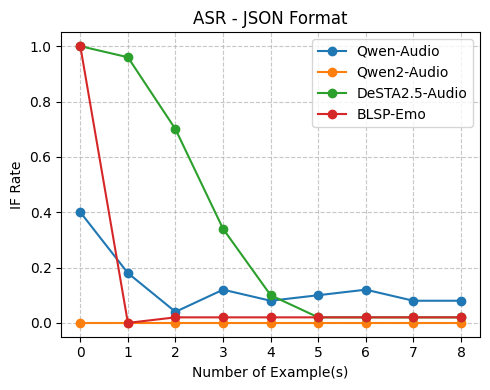

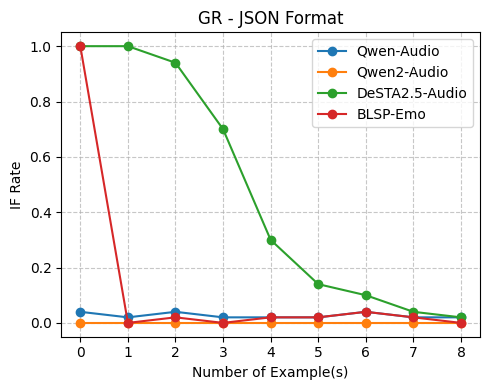

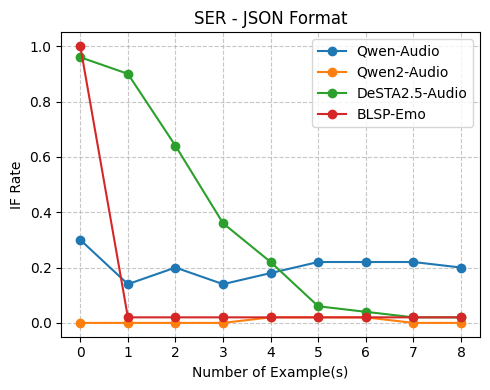

In [6]:
for audio_task in ["ASR", "GR", "SER"]:
    plot_metric_by_shot_level(
        df_audio_task_ceq,
        audio_task=audio_task,
        response_task="closed_ended_questions",
        IF_task_groups=["json_format"],
        metric_name='if_rate_strict',
        figsize=(5, 4)
    )
    plt.savefig(f"./analysis/figures/ceq_{audio_task.lower()}_if.png")

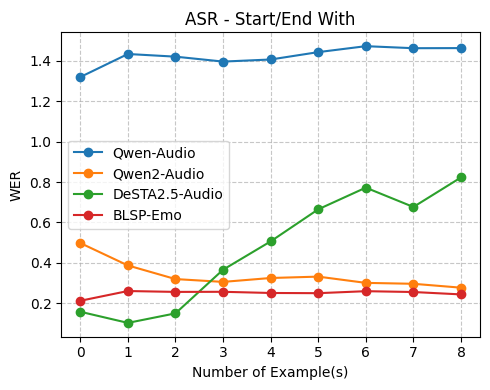

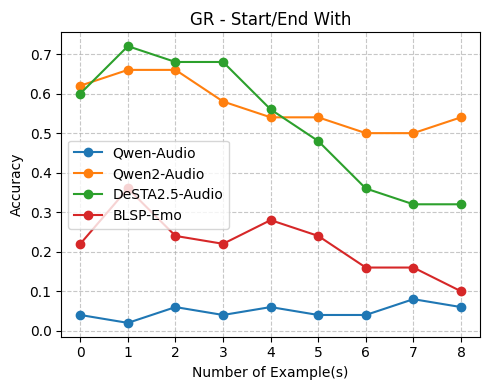

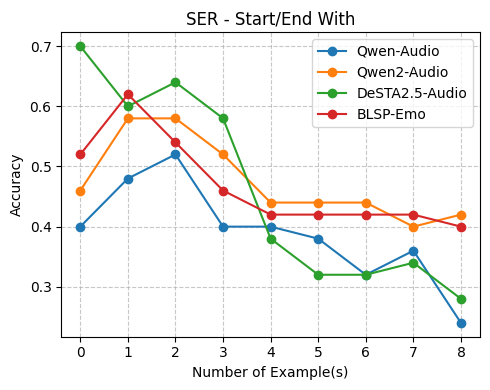

In [7]:
for audio_task in ["ASR", "GR", "SER"]:
    plot_metric_by_shot_level(
        df_audio_task_ceq,
        audio_task=audio_task,
        response_task="closed_ended_questions",
        IF_task_groups=["startend"],
        metric_name='mean_performance',
        figsize=(5, 4),
    )
    metric = "wer" if audio_task == "ASR" else "acc"
    plt.savefig(f"./analysis/figures/ceq_{audio_task.lower()}_{metric}.png")

# creative_writing

In [8]:
df_audio_task_cw = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_cw[audio_task] = pd.read_excel(f"./analysis/summary_cw.xlsx", sheet_name=f"{audio_task}_grouped")

In [9]:
def plot_metric_by_shot_level(
    df_audio_task:dict[str, pd.DataFrame],
    audio_task: str,
    response_task: str,
    IF_task_groups: list[str],
    ylim:Union[tuple[float, float], Any]=None,
    model_order:list[str]=model_order,
    metric_name:str='mean_performance',
) -> None:
    audio_task_formatted = MAP_AUDIO_TASK.get(audio_task, audio_task).replace('_', ' ').title()
    try:
        tmp = df_audio_task[f"{audio_task}_grouped"]
    except KeyError:
        tmp = df_audio_task[audio_task]
    for IF_task_group in IF_task_groups:
        plt.figure(figsize=(5, 4))
        for model in model_order:
            tmp_model = tmp[(tmp['IF_task_group'] == IF_task_group) & (tmp['model'] == model)]
            plt.plot(tmp_model['shot_level'], tmp_model[metric_name], marker='o', label=MAP_MODEL_NAME.get(model, model))
        IF_task_group_formatted = IF_task_group.replace('_', ' ').title()
        plt.xlabel('Number of Example(s)')
        if "if_rate" in metric_name:
            metric_name_formatted = "IF Rate"
            title = f"Instruction-Following Rate of Model\n"
            title += f"{audio_task_formatted} ({audio_task}) - {IF_task_group_formatted}"
            if "if_rate" in metric_name:
                metric_name_formatted = "IF Rate"
                title = f"Instruction-Following Rate of Model\n"
                title += f"Creative Writing - {IF_task_group_formatted}"
        elif "mean_performance" in metric_name:
            metric_name_formatted = "WER" if audio_task == "ASR" else "Accuracy"
            title = f"Task Performance of Model\n"
            title += f"{audio_task_formatted} ({audio_task}) - {IF_task_group_formatted}"
        else:
            raise ValueError(f"Unknown metric name: {metric_name}")
        plt.title(IF_task_group_formatted)
        plt.ylabel(metric_name_formatted)
        if ylim is not None:
            plt.ylim(ylim)
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        metric_name_suffix = "if" if "if_rate" in metric_name else ("wer" if audio_task == "ASR" else "acc")
        IF_task_group_formatted = IF_task_group_formatted.split(" ")[0].lower()
        plt.savefig(f"./analysis/figures/cw_{IF_task_group_formatted}_{metric_name_suffix}.png")

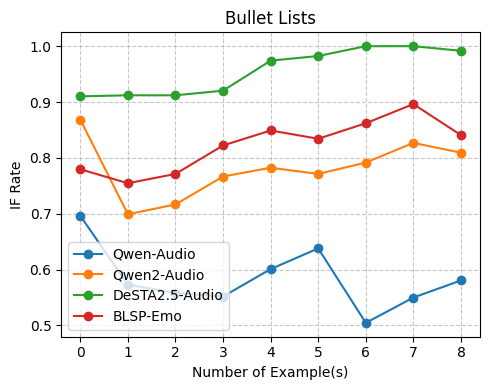

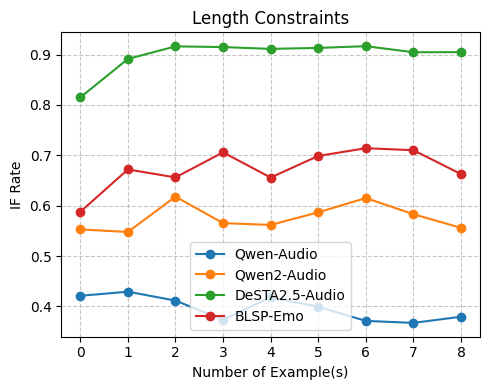

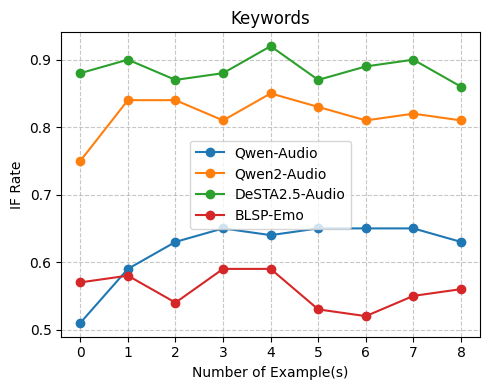

In [10]:
tmp = [v for k, v in df_audio_task_cw.items()]
df_concat = pd.concat(tmp, ignore_index=True)
df_concat = df_concat.dropna()
df_concat = df_concat.groupby(['shot_level', 'IF_task_group', 'model'], observed=False).mean(numeric_only=True).reset_index()
metric_name = 'if_rate'
plot_metric_by_shot_level(
    df_audio_task={'combined': df_concat},
    audio_task='combined',
    response_task="creative_writing",
    IF_task_groups=["bullet_lists", "length_constraints", "keywords"],
    metric_name=metric_name,
)

# CoT

In [11]:
df_audio_task_cot = {}
for audio_task in ["ASR", "GR", "SER"]:
    df_audio_task_cot[audio_task] = pd.read_excel(f"./analysis/summary_CoT.xlsx", sheet_name=audio_task)

In [12]:
def plot_metric_by_shot_level_cot(
    df_audio_task:dict[str, pd.DataFrame],
    audio_task: str,
    metric_name:str='CoT Acc'
) -> None:
    tmp = df_audio_task[f"{audio_task}"]
    audio_task_formatted = MAP_AUDIO_TASK.get(audio_task, audio_task).replace('_', ' ').title()
    for IF_task_group in tmp['IF_task_group'].unique():
        plt.figure(figsize=(5, 4))
        for model in model_order:
            tmp_model = tmp[(tmp['IF_task_group'] == IF_task_group) & (tmp['model'] == model)]
            label = MAP_MODEL_NAME.get(model, model)
            if metric_name == 'task wer':
                plt.plot(tmp_model['shot_level'], tmp_model[metric_name], marker='o', label=label)
                plt.ylabel("WER")
            elif metric_name == 'Task Acc':
                plt.plot(tmp_model['shot_level'], tmp_model["Task Acc"], marker='o', label=label)
                plt.ylabel("Accuracy")
            elif metric_name == "CoT Acc":
                plt.plot(tmp_model['shot_level'], tmp_model["CoT Acc"], marker='o', label=label)
                plt.ylabel("IF Rate")
        if metric_name == "CoT Acc":
            title = f"Instruction-Following Rate of Model with Chain-of-Thought\n"
            title += f"{audio_task_formatted} ({audio_task})"
        elif metric_name == 'task wer' or metric_name == 'Task Acc':
            title = f"Task Performance of Model with Chain-of-Thought\n"
            title += f"{audio_task_formatted} ({audio_task})"
        else:
            raise ValueError(f"Unknown metric name: {metric_name}")

        plt.title(audio_task)
        plt.xlabel('Number of Example(s)')
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()

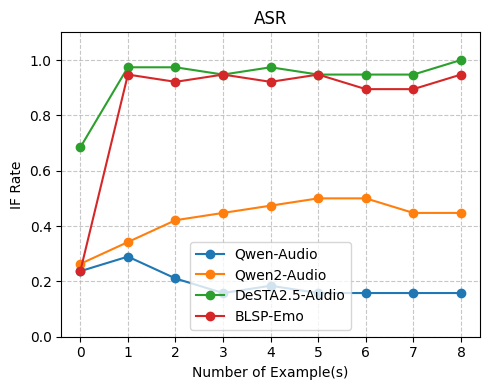

In [16]:
for audio_task in ["ASR"]:
    plot_metric_by_shot_level_cot(
        df_audio_task_cot,
        audio_task=audio_task,
        metric_name='CoT Acc'
    )
    plt.ylim(0, 1.1)

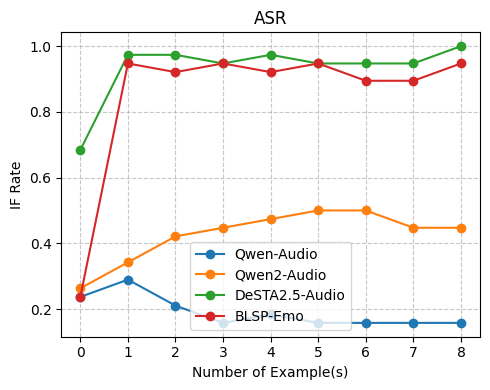

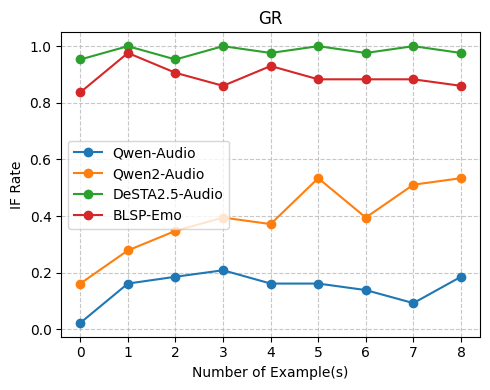

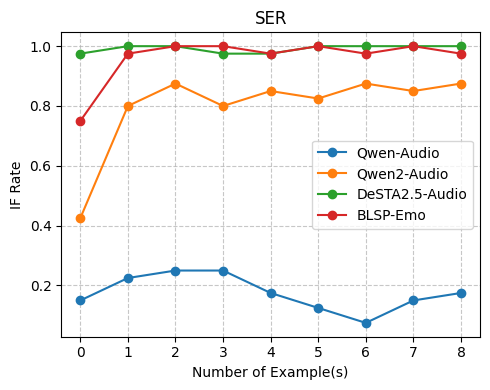

In [13]:
for audio_task in ["ASR", "GR", "SER"]:
    plot_metric_by_shot_level_cot(
        df_audio_task_cot,
        audio_task=audio_task,
        metric_name='CoT Acc'
    )
    metric = "if"
    plt.savefig(f"./analysis/figures/cot_{audio_task.lower()}_{metric}.png")

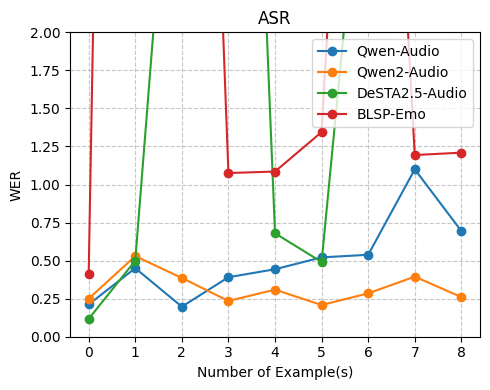

In [18]:
for audio_task, metric_name in zip(["ASR"], ['task wer']):
    plot_metric_by_shot_level_cot(
        df_audio_task_cot,
        audio_task=audio_task,
        metric_name=metric_name
    )
    plt.ylim(0, 2)

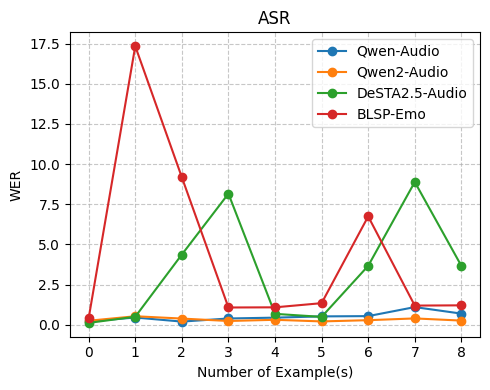

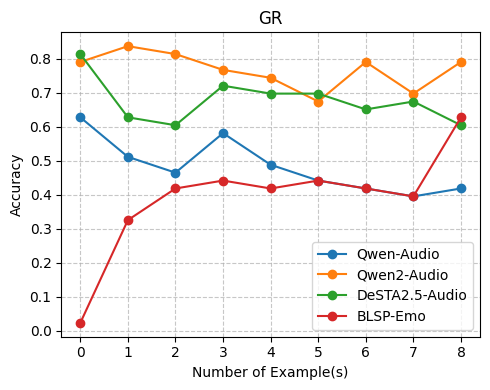

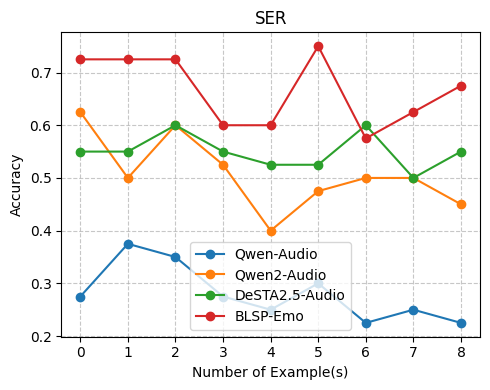

In [14]:
for audio_task, metric_name in zip(["ASR", "GR", "SER"], ['task wer', 'Task Acc', 'Task Acc']):
    plot_metric_by_shot_level_cot(
        df_audio_task_cot,
        audio_task=audio_task,
        metric_name=metric_name
    )
    metric = "wer" if audio_task == "ASR" else "acc"
    plt.savefig(f"./analysis/figures/cot_{audio_task.lower()}_{metric}.png")